In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import tensorflow as tf
# supresses future warnings
import warnings
warnings.simplefilter(action='ignore')

# Import the matplotlib library for plotting
import matplotlib.pyplot as plt

from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.utils import read_sample

import seaborn as sns

In [73]:
# Set the random seed for reproducibility
np.random.seed(42)

# Number of rows in the dataset
n_rows = 150

# Generate random patient and doctor IDs
patient_ids = ['P{}'.format(i) for i in range(1, n_rows+1)]
doctor_ids = ['D{}'.format(i) for i in range(1, 13)]

# Generate random dates
dates = pd.date_range(start='2023-01-01', periods=n_rows, freq='D').strftime('%d-%b-%y')

# List of specialties and services
specialties_services = {
'Cardiology': ['Echocardiogram', 'Stress test', 'Angiogram'],
'Dermatology': ['Acne treatment', 'Skin biopsy'],
'Pediatrics': ['Vaccinations', 'Well-child checkup', 'Ear infection treatment'],
'Orthopedics': ['X-ray', 'Physical therapy'],
'Gynecology': ['Pap smear', 'Birth control consultation'],
'Ophthalmology': ['Eye exam', 'Cataract surgery'],
'Neurology': ['MRI scan']
}


# Assign a unique specialty to each doctor
specialties = list(specialties_services.keys())
np.random.shuffle(specialties)
doctor_specialty = {}
for i, doctor in enumerate(doctor_ids):
    doctor_specialty[doctor] = specialties[i % len(specialties)]


# Create a list of doctor-specialty tuples
doctor_specialty_tuples = [(doctor, specialty) for doctor, specialty in doctor_specialty.items()]

# Generate random doctor-specialty tuples for each row
random_doctor_specialty = np.random.choice(len(doctor_specialty_tuples), size=n_rows)

# Extract the doctor IDs and specialties from the randomly selected tuples
random_doctors = [doctor_specialty_tuples[i][0] for i in random_doctor_specialty]
random_specialties = [doctor_specialty_tuples[i][1] for i in random_doctor_specialty]

# Generate random services
random_services = []
for specialty in random_specialties:
    services = specialties_services[specialty]
    selected_services = ', '.join(np.random.choice(services, size=np.random.randint(1, len(services) + 1)))
    random_services.append(selected_services)

# Create a DataFrame
data = pd.DataFrame({
    'Patient ID': patient_ids,
    'Doctor ID': random_doctors,
    'Date': dates,
    'Specialty': random_specialties,
    'Services': random_services,
     'Label':['Normal'] * (n_rows // 2) + ['Investigate'] * (n_rows // 2)})



# Introduce fraud with illogical service-specialty combinations
for i in range(5):
    row_idx = np.random.randint(n_rows)
    random_specialty = np.random.choice(list(specialties_services.keys()))
    random_service = np.random.choice(sum(specialties_services.values(), []))
    while random_service in specialties_services[random_specialty]:
        random_service = np.random.choice(sum(specialties_services.values(), []))
        data.loc[row_idx, 'Specialty'] = random_specialty
        data.loc[row_idx, 'Services'] = random_service
        data.loc[row_idx, 'Label'] = 'Fraud'



# Introduce fraud with repeated services for the same patient
for i in range(5):
    row_idx1, row_idx2 = np.random.randint(n_rows, size=2)
    while row_idx1 == row_idx2:
        row_idx2 = np.random.randint(n_rows)
        data.loc[row_idx2, 'Patient ID'] = data.loc[row_idx1, 'Patient ID']
        data.loc[row_idx2, 'Specialty'] = data.loc[row_idx1, 'Specialty']
        data.loc[row_idx2, 'Services'] = data.loc[row_idx1, 'Services']
        data.loc[row_idx2, 'Label'] = 'Fraud'

In [74]:
data

,Patient ID,Doctor ID,Date,Specialty,Services,Label
0,P1,D5,01-Jan-23,Gynecology,Birth control consultation,Normal
1,P2,D7,02-Jan-23,Neurology,MRI scan,Normal
2,P3,D10,03-Jan-23,Ophthalmology,Cataract surgery,Normal
3,P4,D3,04-Jan-23,Ophthalmology,"Cataract surgery, Eye exam",Normal
4,P5,D7,05-Jan-23,Neurology,MRI scan,Normal
...,...,...,...,...,...,...
145,P146,D10,26-May-23,Ophthalmology,"Cataract surgery, Eye exam",Investigate
146,P147,D10,27-May-23,Ophthalmology,"Cataract surgery, Cataract surgery",Investigate
147,P148,D12,28-May-23,Gynecology,"Pap smear, Pap smear",Investigate
148,P149,D3,29-May-23,Ophthalmology,"Eye exam, Eye exam",Investigate


In [4]:
# Convert 'Date' column to numerical representation
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data['Date'] = data['Date'].apply(lambda x: x.toordinal())

In [5]:
#data['Date'] = [i.replace('-','') for i in data['Date']]


In [6]:
#data.set_index('Date',inplace =True)

In [7]:
data['Specialty'].unique().tolist()

['Gynecology',
 'Neurology',
 'Ophthalmology',
 'Pediatrics',
 'Cardiology',
 'Orthopedics',
 'Dermatology']

In [8]:
all_list = ((data['Specialty'].unique()).tolist() + (data['Services'].unique()).tolist() + (data['Label'].unique()).tolist() + (data['Patient ID'].unique()).tolist() + (data['Doctor ID'].unique()).tolist())
print(data.isnull().sum())

print('done!')
data.head()

Patient ID    0
Doctor ID     0
Date          0
Specialty     0
Services      0
Label         0
dtype: int64
done!


,Patient ID,Doctor ID,Date,Specialty,Services,Label
0,P1,D5,738521,Gynecology,Birth control consultation,Normal
1,P2,D7,738522,Neurology,MRI scan,Normal
2,P3,D10,738523,Ophthalmology,Cataract surgery,Normal
3,P4,D3,738524,Ophthalmology,"Cataract surgery, Eye exam",Normal
4,P5,D7,738525,Neurology,MRI scan,Normal


In [9]:
uni_len = '***'.join(all_list)
nat_enc = tf.keras.preprocessing.text.Tokenizer(num_words=len(all_list),
    filters='',
    lower=False,
    split = '***')
nat_enc.fit_on_texts([uni_len])
nat_dic = nat_enc.word_index
print(len(list(nat_dic)))

225


In [10]:
for step, val in enumerate(data['Patient ID']):
    data['Patient ID'].iloc[step] = (nat_dic.get(val))
for step, val in enumerate(data['Doctor ID']):
    data['Doctor ID'].iloc[step] = (nat_dic.get(val))
for step, val in enumerate(data['Specialty']):
    data['Specialty'].iloc[step] = (nat_dic.get(val))
for step, val in enumerate(data['Services']):
    data['Services'].iloc[step] = (nat_dic.get(val))
for step, val in enumerate(data['Label']):
    if data['Label'].iloc[step] == 'Normal':
        data['Label'].iloc[step] = 0
    if data['Label'].iloc[step] == 'Investigate':
        data['Label'].iloc[step] = 1


print(data.isnull().sum())

Patient ID    0
Doctor ID     0
Date          0
Specialty     0
Services      0
Label         0
dtype: int64


In [11]:
data.head()

,Patient ID,Doctor ID,Date,Specialty,Services,Label
0,64,214,738521,1,8,0
1,65,215,738522,2,9,0
2,66,216,738523,3,10,0
3,67,217,738524,3,11,0
4,68,215,738525,2,9,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  150 non-null    object
 1   Doctor ID   150 non-null    object
 2   Date        150 non-null    int64 
 3   Specialty   150 non-null    object
 4   Services    150 non-null    object
 5   Label       150 non-null    object
dtypes: int64(1), object(5)
memory usage: 7.2+ KB


In [13]:
## Printing the Unique  Value of each column
print(data.apply(lambda col: col.unique()))

Patient ID    [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 7...
Doctor ID     [214, 215, 216, 217, 218, 219, 220, 221, 222, ...
Date          [738521, 738522, 738523, 738524, 738525, 73852...
Specialty                                 [1, 2, 3, 4, 5, 6, 7]
Services      [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...
Label                                                    [0, 1]
dtype: object


In [22]:
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler

# Select the columns for clustering
columns_for_clustering = [
   'Patient ID', 'Doctor ID', 'Specialty', 'Services', 'Label'
]

# Prepare the data for clustering
X = data[columns_for_clustering]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform G-means clustering
gmeans = KMedoids(n_clusters=4, random_state=0)
clusters = gmeans.fit_predict(X_scaled)

# Add the cluster labels to the DataFrame
data['Cluster'] = clusters



In [23]:
# Compute association scores
patient_association_scores = data.groupby('Patient ID')['Cluster'].mean()
doctor_association_scores = data.groupby('Doctor ID')['Cluster'].mean()
service_association_scores = data.groupby('Services')['Cluster'].mean()

# Apply threshold on association scores
patient_threshold = 0.5
doctor_threshold = 0.5
service_threshold = 0.5


In [24]:
data['Patient Association Score'] = data['Patient ID'].map(patient_association_scores)
data['Doctor Association Score'] = data['Doctor ID'].map(doctor_association_scores)
data['Service Association Score'] = data['Services'].map(service_association_scores)

data['Patient Status'] = np.where(data['Patient Association Score'] >= patient_threshold, 'Normal', 'Investigate')
data['Doctor Status'] = np.where(data['Doctor Association Score'] >= doctor_threshold, 'Normal', 'Investigate')
data['Service Status'] = np.where(data['Service Association Score'] >= service_threshold, 'Normal', 'Investigate')


In [28]:
data.head()

,Unnamed: 0,Patient ID,Doctor ID,Date,Specialty,Services,Label,Cluster,Patient Association Score,Doctor Association Score,Service Association Score,Patient Status,Doctor Status,Service Status
0,0,64,214,738521,1,8,0,2,2.0,2.384615,2.600000,Normal,Normal,Normal
1,1,65,215,738522,2,9,0,2,2.0,2.600000,2.600000,Normal,Normal,Normal
2,2,66,216,738523,3,10,0,2,2.0,2.428571,2.250000,Normal,Normal,Normal
3,3,67,217,738524,3,11,0,2,2.0,2.357143,2.666667,Normal,Normal,Normal
4,4,68,215,738525,2,9,0,2,2.0,2.600000,2.600000,Normal,Normal,Normal


In [29]:
## Printing the Unique  Value of each column
print(data.apply(lambda col: col.unique()))

Unnamed: 0                   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Patient ID                   [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 7...
Doctor ID                    [214, 215, 216, 217, 218, 219, 220, 221, 222, ...
Date                         [738521, 738522, 738523, 738524, 738525, 73852...
Specialty                                                [1, 2, 3, 4, 5, 6, 7]
Services                     [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...
Label                                                                   [0, 1]
Cluster                                                           [2, 0, 1, 3]
Patient Association Score                                 [2.0, 0.0, 1.0, 3.0]
Doctor Association Score     [2.3846153846153846, 2.6, 2.4285714285714284, ...
Service Association Score    [2.6, 2.25, 2.6666666666666665, 2.0, 0.0, 2.2,...
Patient Status                                           [Normal, Investigate]
Doctor Status                                       

In [30]:
# Prepare the data for clustering
data_for_clustering = data[['Patient Association Score', 'Doctor Association Score', 'Service Association Score']].values


In [32]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
data_for_clustering = scaler.fit_transform(data_for_clustering)


In [55]:
k = 5

In [56]:
# Perform G-means clustering
gmeans_instance = gmeans(data_for_clustering, k)
gmeans_instance.process()

In [57]:
# Get the clusters and centers
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()


In [63]:
# Assign cluster labels to data points
data['G_Cluster'] = None
for cluster_id, cluster in enumerate(clusters):
    data.loc[cluster, 'G_Cluster'] = cluster_id

In [65]:
## Printing the Unique  Value of each column
print(data.apply(lambda col: col.unique()))

Unnamed: 0                   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Patient ID                   [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 7...
Doctor ID                    [214, 215, 216, 217, 218, 219, 220, 221, 222, ...
Date                         [738521, 738522, 738523, 738524, 738525, 73852...
Specialty                                                [1, 2, 3, 4, 5, 6, 7]
Services                     [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...
Label                                                                   [0, 1]
Cluster                                                           [2, 0, 1, 3]
Patient Association Score                                 [2.0, 0.0, 1.0, 3.0]
Doctor Association Score     [2.3846153846153846, 2.6, 2.4285714285714284, ...
Service Association Score    [2.6, 2.25, 2.6666666666666665, 2.0, 0.0, 2.2,...
Patient Status                                           [Normal, Investigate]
Doctor Status                                       

In [88]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
for step, val in enumerate(data['Label']):
    if data['Label'].iloc[step] == 'Normal':
        data['Label'].iloc[step] = 0
    if data['Label'].iloc[step] == 'Investigate':
        data['Label'].iloc[step] = 1

# Convert the data to a transaction format
transactions = data[['Specialty', 'Label']]



# Apply one-hot encoding to create binary values for each service
one_hot_encoded = pd.get_dummies(transactions['Specialty'], prefix='Service')

# Concatenate the specialty and one-hot encoded services
transactions = pd.concat([transactions['Label'], one_hot_encoded], axis=1)



In [89]:
transactions

,Label,Service_Cardiology,Service_Dermatology,Service_Gynecology,Service_Neurology,Service_Ophthalmology,Service_Orthopedics,Service_Pediatrics
0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
145,1,0,0,0,0,1,0,0
146,1,0,0,0,0,1,0,0
147,1,0,0,1,0,0,0,0
148,1,0,0,0,0,1,0,0


In [90]:

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(transactions, min_support=0.1, use_colnames=True)

# Generate association rules with minimum confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)



In [91]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Service_Cardiology),(Label),0.173333,0.5,0.113333,0.653846,1.307692,0.026667,1.444444


In [92]:
def calculate_similarity(patient_specialty, patient_services, rule_specialty, rule_services):
    specialty_similarity = int(patient_specialty == rule_specialty)

    patient_services_set = set(patient_services)
    rule_services_set = set(rule_services)
    service_similarity = len(patient_services_set.intersection(rule_services_set)) / len(patient_services_set.union(rule_services_set))

    similarity_score = (specialty_similarity + service_similarity) / 2
    return similarity_score

# Example data
patient_specialty = 1
patient_services = [8, 9, 10]
rule_specialty = 1
rule_services = [8, 9, 10, 11]

# Calculate the similarity between patient data and rule data
similarity_score = calculate_similarity(patient_specialty, patient_services, rule_specialty, rule_services)
print(f"Similarity score: {similarity_score}")


Similarity score: 0.875


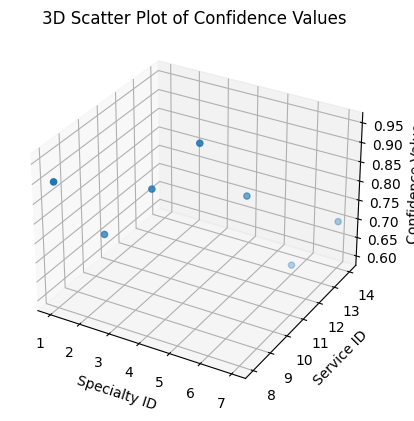

In [99]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
ax.scatter(specialty_ids, service_ids, confidence_values)

# Set labels and title
ax.set_xlabel('Specialty ID')
ax.set_ylabel('Service ID')
ax.set_zlabel('Confidence Value')
ax.set_title('3D Scatter Plot of Confidence Values')

# Show the plot
plt.show()
